## Analysis of hydrophobicity scales

Author: Giulio Tesei

Contact: giulio.tesei@bio.ku.dk

The cells below detail the analysis of the hydrophobicity scales collected by Simm et al. [DOI: 10.1186/s40659-016-0092-5](https://doi.org/10.1186/s40659-016-0092-5).

In [67]:
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import string
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from itertools import permutations, combinations
from scipy.optimize import curve_fit
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.neighbors import KernelDensity
from sklearn.covariance import LedoitWolf, ShrunkCovariance
import math
from cycler import cycler

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)
    print(linkage_matrix.shape)
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

The cell below:

* loads the parameters of the C$\alpha$-based model by Dignon et al. [DOI: 10.1371/journal.pcbi.1005941](https://doi.org/10.1371/journal.pcbi.1005941).

* loads and min-max normalizes the hydrophobicity scales collected by Simm et al. [DOI: 10.1186/s40659-016-0092-5](https://doi.org/10.1186/s40659-016-0092-5).

In [3]:
url = """https://static-content.springer.com/esm/art%3A10.1186%2Fs40659-016-0092-5/MediaObjects/
40659_2016_92_MOESM1_ESM.xlsx""".replace('\n','')

In [4]:
oneletter = ['R','D','N','E','K','H','Q','S','C','G','T','A',
             'M','Y','V','W','L','I','P','F']
ordered = ['ARG','ASP','ASN','GLU','LYS','HIS','GLN','SER','CYS','GLY','THR','ALA',
           'MET','TYR','VAL','TRP','LEU','ILE','PRO','PHE']
dfsigma = pd.read_csv('prior/sigmas.txt',names=['resname','sigmas'],index_col=0,
                      delimiter=' ')
dflambda = pd.read_csv('prior/lambdas.txt',names=['resname','lambdas'],index_col=0,
                       delimiter=' ')

allHPS = pd.read_excel(url,index_col='scale',
                       usecols=[3]+list(range(5,25))).T
map_dict = {three.capitalize(): one for three,one in zip(ordered,oneletter)}
allHPS.index = allHPS.index.map(mapper=map_dict)
allHPS = allHPS.loc[oneletter]
allHPS = (allHPS-allHPS.min())/(allHPS.max()-allHPS.min())

In [5]:
# Selection of unique min-max normalized scales
sel = ['Wimley', 'BULDG reverse', 'MANP780101', 'VHEG790101', 'JANIN', 'JANJ790102', 
       'WOLR790101', 'PONP800101', 'PONP800102', 'PONP800103', 'PONP800104', 'PONP800105',
       'PONP800106', 'Wilson', 'FAUCH', 'ENGEL', 'ROSEM', 'JACWH', 
       'CowanWhittacker', 'ROSM880101 reverse', 'ROSM880102 reverse', 'COWR900101', 
       'BLAS910101', 'CASSI', 'CIDH920101', 'CIDH920105', 'CIDBB', 'CIDA+', 'CIDAB', 
       'PONG1', 'PONG2', 'PONG3', 'WILM950101', 'WILM950102', 'WILM950104', 'Bishop reverse', 
       'NADH010101', 'NADH010102', 'NADH010103', 'NADH010104', 'NADH010105', 'NADH010106',
       'NADH010107', 'ZIMJ680101', 'NOZY710101\nTanford', 'JONES', 'LEVIT', 'KYTJ820101', 
       'SWER830101','SWEET', 'EISEN', 'ROSEF', 'GUYFE', 'COHEN', 'NNEIG', 'MDK0', 'MDK1', 
       'JURD980101', 'SET1', 'SET2', 'SET3', 'CHOTA', 'CHOTH', 'Sweet & Eisenberg', 'KIDER', 
       'ROSEB', 'Welling reverse', 'Rao & Argos', 'GIBRA', 'WOLR810101 reverse']
selHPS = allHPS[sel]
selHPS.to_csv('prior/selHPS.csv')

In [6]:
one = pd.Series({three: one for three,one in zip(ordered,oneletter)},name='one')
# molecular weights and molar volumes of the free amino 
# acid from Kharakoz et al. (DOI: 10.1021/bi961781c).
mw = pd.read_csv('prior/molar_volumes.dat',header=0,sep='\t',
                 index_col=0,usecols=[0,1,2],names=['three','MW','Vol'])
mw.index = mw.index.str.upper()
dfparams = pd.concat([one,dflambda,dfsigma/10,mw.MW],axis=1,sort=True).dropna().loc[ordered]
dfparams['q'] = [0]*dfparams.index.size # assign amino acid charges
dfparams.loc['ARG','q'] = 1
dfparams.loc['LYS','q'] = 1
dfparams.loc['GLU','q'] = -1
dfparams.loc['ASP','q'] = -1
dfparams['three'] = dfparams.index
centile10 = selHPS.quantile(.1,axis=1)
centile90 = selHPS.quantile(.9,axis=1)
average = selHPS.mean(axis=1)
dfparams['centile10'] = centile10.values
dfparams['centile90'] = centile90.values
dfparams['HPS'] = dfparams.lambdas
dfparams['AVG'] = average.values
dfparams['M1'] = [0.72499159, 0.02918212, 0.4383273 , 0.00610028, 0.05861717,
       0.46519481, 0.32681881, 0.46485701, 0.61036235, 0.70127137,
       0.53797776, 0.00111626, 0.74589934, 0.99501082, 0.41850069,
       0.98442355, 0.55630203, 0.60752683, 0.37296419, 0.92169598]
dfparams['Urry'] = [0.558824, 0.294119, 0.588236, 0.      , 0.382354, 0.764707,
       0.558824, 0.588236, 0.64706 , 0.57353 , 0.588236, 0.602942,
       0.676471, 0.897059, 0.664707, 1.      , 0.720589, 0.705883,
       0.758824, 0.82353 ]
dfparams.to_csv('residues.csv')

(69, 4)


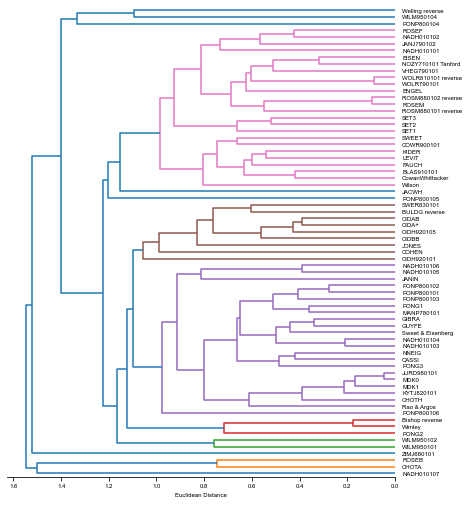

In [7]:
fig = plt.figure(figsize=(6.5,7))

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

X = selHPS.T.values

model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average', 
                                affinity='euclidean')
model = model.fit(X)

plot_dendrogram(model, truncate_mode='level', p=14, labels=selHPS.columns,
                leaf_rotation=0, orientation='left', distance_sort=True)

        
labels = [ticklabel.get_text().replace('\n',' ') for ticklabel in plt.gca().get_yticklabels()]
plt.gca().set_yticklabels(labels)
        
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['left'].set_visible(False)

plt.xlabel('Euclidean Distance')

plt.tight_layout()
plt.savefig('figs/dendrogram.pdf')

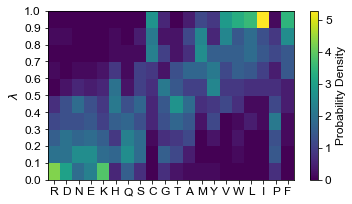

In [8]:
cols = np.arange(0,1.1,.1)
dfprior = pd.DataFrame(index=selHPS.index,columns=pd.cut(cols[1:],cols),
                    data=np.zeros((selHPS.index.size,np.arange(0.05,1.05,.1).size)))
for i in range(dfprior.index.size):
    h, _ = np.histogram(selHPS.iloc[i].values,bins=cols,density=True)
    dfprior.loc[selHPS.iloc[i].name] = h

plt.figure(figsize=(5.2,3))
plt.rcParams.update({ 'font.size': 12 })
c = plt.pcolor(dfprior.T)
plt.xticks(np.arange(.5,20,1),labels=dfprior.index)
plt.ylabel('$\lambda$')
plt.yticks(range(11),['{:.1f}'.format(i) for i in np.arange(0,1.1,.1)])
plt.colorbar(c,label='Probability Density')
plt.tight_layout()
plt.show()

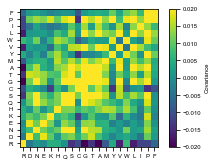

In [9]:
f = plt.figure(figsize=(3,3))

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
covMatrix = np.cov(selHPS.T.values.T)
im = plt.pcolor(covMatrix, cmap=plt.cm.viridis, vmin=-.02, vmax=0.02)

plt.xticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
plt.yticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
plt.gca().set_aspect('equal')
divider = make_axes_locatable(plt.gca())
cax = divider.new_horizontal(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='vertical', label='Covariance')
plt.tight_layout()
plt.show()

Calculate KDE for each aa. 

In [10]:
prior_kde = {}
for a in selHPS.index:
    kde = KernelDensity(kernel='gaussian',
                    bandwidth=0.05).fit(selHPS.loc[a].values[:, None])
    prior_kde[a] = kde

Calculate multivariate KDE for all aa. 

In [11]:
kde = KernelDensity(kernel='gaussian',bandwidth=.05).fit(selHPS.T.values)

Calculate the 1D projections of the multivariate KDE averaging over all the scales. 

In [12]:
prior_kde_1D = {}
cols = np.arange(-.2,1.2,.01)

for a in dfprior.index:
    mat = np.empty((cols[:-1].size,selHPS.T.index.size))
    for i,x in enumerate(cols[:-1]+0.005):
        for j,y in enumerate(selHPS.T.index):
            scale = selHPS.T.loc[y].copy()
            scale[a] = x
            mat[i,j] = np.exp(kde.score_samples(scale.values.reshape(1,-1))[0])
    prior_kde_1D[a] = mat.mean(axis=1)/np.trapz(mat.mean(axis=1),dx=.01)

Calculate mean values from 1D projections. 

In [13]:
cols = np.arange(-.2,1.2,.01)
prior_kde_means = {}
for a in prior_kde_1D.keys():
    prior_kde_means[a] = np.average(cols[:-1]+0.005,weights=prior_kde_1D[a])

Calculate the covariance of the multivariate KDE averaging over all the scales. 

In [14]:
import itertools
covmat = pd.DataFrame(index=selHPS.index,columns=selHPS.index,data=0)
prob_sum = pd.DataFrame(index=selHPS.index,columns=selHPS.index,data=0)

cols = np.arange(-.2,1.2,.1)

for a,b in itertools.combinations(dfprior.index,2):
    for i,x in enumerate(cols[:-1]+0.05):
        for j,y in enumerate(cols[:-1]+0.05):
            for z in selHPS.T.index:
                scale = selHPS.T.loc[z].copy()
                scale[a] = x
                scale[b] = y
                prob = np.exp(kde.score_samples(scale.values.reshape(1,-1))[0])
                covmat.loc[a,b] += prob*(x-prior_kde_means[a])*(y-prior_kde_means[b])
                prob_sum += prob

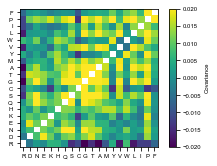

In [15]:
f = plt.figure(figsize=(3,3))


plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
covMatrix = np.cov(selHPS.T.values.T)
covMatrix_mix = np.where(np.tril(np.ones(covMatrix.shape),k=-1).astype(bool),
                         covMatrix,200*(covmat/prob_sum).values)
np.fill_diagonal(covMatrix_mix,np.nan)
im = plt.pcolor(covMatrix_mix, cmap=plt.cm.viridis, vmin=-.02, vmax=0.02)
plt.xticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
plt.yticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
plt.gca().set_aspect('equal')
divider = make_axes_locatable(plt.gca())
cax = divider.new_horizontal(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='vertical', label='Covariance')
plt.tight_layout()
plt.savefig('figs/kde_covariance.pdf')
plt.show()

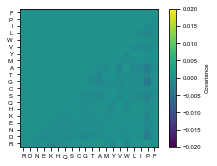

In [16]:
f = plt.figure(figsize=(3,3))

plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})
covMatrix = np.cov(selHPS.T.values.T)
covMatrix_mix = np.where(np.tril(np.ones(covMatrix.shape),k=0).astype(bool),
                         covMatrix,200*(covmat/prob_sum).values)
im = plt.pcolor(covMatrix-covMatrix_mix, cmap=plt.cm.viridis, vmin=-.02, vmax=0.02)
plt.xticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
plt.yticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
plt.gca().set_aspect('equal')
divider = make_axes_locatable(plt.gca())
cax = divider.new_horizontal(size="5%", pad=.15)
f.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='vertical', label='Covariance')
plt.tight_layout()
plt.show()

Plot 1D histograms together with the 1D projections of the multivariate KDE.

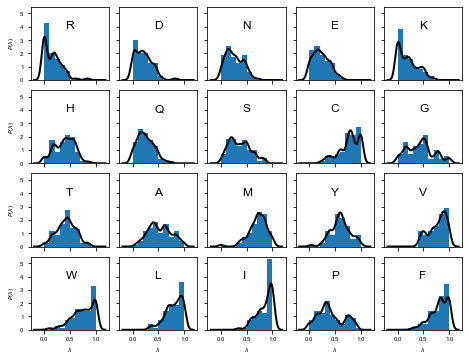

In [87]:
fig, axes = plt.subplots(4, 5, sharex=True, sharey=True, figsize=(6.5,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

for ax,a in zip(axes.flatten()[:],dfprior.index):
    ax.bar(np.arange(.05,1,.1),dfprior.loc[a].values,width=.1)
    
    cols = np.arange(-.2,1.2,.01)
    logprob = prior_kde[a].score_samples(cols[:-1, None]+0.005)
    ax.plot(cols[:-1, None]+0.005, np.exp(logprob),zorder=2,color='k',lw=2)
    
    ax.grid(False)
    ax.set_ylim(1e-5,6)
    ax.set_ylim(0,5.5)
    ax.annotate(a,xy=(.45,.7),xycoords='axes fraction',fontsize=12)
for ax in axes.flatten()[-5:]:
    ax.set_xlabel('$\lambda$')
for i in [0,5,10,15]:
    axes.flatten()[i].set_ylabel('$P(\lambda)$')
plt.tight_layout()
plt.savefig('figs/kde_marginals.pdf')
plt.show()

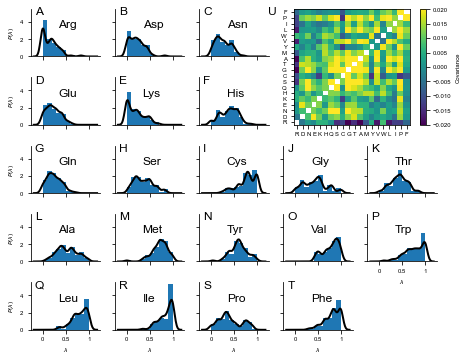

In [91]:
fig, axes = plt.subplots(5, 5, sharex=False, sharey=True, figsize=(6.5,5))
plt.rc('font', **{'family':'sans-serif','sans-serif':['Arial'], 'size': 6})

for ax,a,letter in zip(np.delete(axes.flatten(),[3,4,8,9]),dfprior.index,string.ascii_uppercase):
    ax.bar(np.arange(.05,1,.1),dfprior.loc[a].values,width=.1)
    
    cols = np.arange(-.2,1.2,.01)
    logprob = prior_kde[a].score_samples(cols[:-1, None]+0.005)
    ax.plot(cols[:-1, None]+0.005, np.exp(logprob),zorder=2,color='k',lw=2)
    
    ax.grid(False)
    ax.set_ylim(1e-5,6)
    ax.set_ylim(0,5.5)
    ax.annotate(string.capwords(dfparams.set_index('one').loc[a].three),
                xy=(.4,.6),xycoords='axes fraction',fontsize=12)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.annotate(letter, (.06,.88), fontsize=12, xycoords='axes fraction')
    
for ax in axes.flatten()[:-6]:
    ax.set_xticks([0,.5,1])
    ax.set_xticklabels([])
for ax in axes.flatten()[-6:]:
    ax.set_xlabel('$\lambda$')
    ax.set_xticks([0,.5,1])
    ax.set_xticklabels([0,.5,1])
for i in range(5):
    axes[i,0].set_ylabel('$P(\lambda)$')
    
gs = axes[0,3].get_gridspec()
for i,j in zip([0,0,1,1,4],[3,4,3,4,4]):
    axes[i,j].remove()
axbig = fig.add_subplot(gs[0:2, 3:5])

covMatrix = np.cov(selHPS.T.values.T)
covMatrix_mix = np.where(np.tril(np.ones(covMatrix.shape),k=-1).astype(bool),
                         covMatrix,200*(covmat/prob_sum).values)
np.fill_diagonal(covMatrix_mix,np.nan)
im = axbig.pcolor(covMatrix_mix, cmap=plt.cm.viridis, vmin=-.02, vmax=0.02)
plt.xticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
plt.yticks(np.arange(.5,selHPS.index.size,1),selHPS.index)
axbig.set_aspect('equal')
divider = make_axes_locatable(axbig)
cax = divider.new_horizontal(size="5%", pad=.15)
fig.add_axes(cax)
cb = f.colorbar(im, cax=cax, orientation='vertical', label='Covariance')

axes[0,2].annotate('U', (.99,.88), fontsize=12, xycoords='axes fraction')

plt.tight_layout(h_pad=-.5,w_pad=.5)
plt.savefig('figs/kde_covariance_marginals.pdf')
plt.show()